In [1]:
import numpy as np
from scipy.linalg import eigh_tridiagonal
from numpy.random import randint, rand
from scipy.sparse import random
from scipy.sparse import csr_matrix
from matplotlib import pyplot as plt
import time
from numba import njit
from lanczos import lanczos_eig
import multiprocessing
from tqdm.contrib.concurrent import process_map

In [2]:
#qiskit colour palet
darkpurple = (48/255, 19/255, 94/255)
purple = (105/255, 40/255, 195/255)
background2 = (242/255, 243/255, 248/255)
background1 = (221/255, 225/255, 230/255)

In [3]:
def rand_herm(size,sparsity):
    sparsity = 1 - np.sqrt(1 - sparsity)
    mat = np.zeros(size*size)
    nonzero_num = int(size*size*sparsity)
    nonzero_idx = randint(0, size**2, size=nonzero_num)
    mat[nonzero_idx] = rand(nonzero_num)
    mat = mat.reshape(size, size)
    mat = mat + mat.T
    return mat

In [4]:
def rand_herm_sparse(size,sparsity):
    sparsity = 1 - np.sqrt(1 - sparsity)
    mat = random(size,size,density=sparsity,format='csr')
    mat = mat + mat.T
    return mat

In [5]:
def LanczosVsNumpy(size, sparsity, k, repeats):
    tlanc_list = []
    teigh_list = []
    fidelity_list = []
    
    for idx in range(repeats):
        mat = rand_herm(size, sparsity)

        t0 = time.time()

        x = rand(size)
        _, W1 = lanczos_eig(mat,x,k)
        eiglanc = W1[:,0]

        t1 = time.time()

        _, W2 = np.linalg.eigh(mat)
        eigres = W2[:,0]

        t2 = time.time()

        fidelity = np.abs(eigres @ eiglanc)
        tlanc = t1 - t0
        teigh = t2 - t1
        
        fidelity_list.append(fidelity)
        tlanc_list.append(tlanc)
        teigh_list.append(teigh)
    
    return np.mean(tlanc_list), np.mean(teigh_list), np.mean(fidelity_list)

In [6]:
# LanczosVsNumpy(1000, 0.2, 40, 100)
runtime_vals = []
for size_idx in range(300,1500,20):
    runtime_vals.append(LanczosVsNumpy(size_idx, 0.3, min(50+int(10*size_idx/1500),size_idx//10), 100))
    
# np.save('lanc_comp2.npy', np.array(runtime_vals))
runtime_vals = np.load('simdata/lanc_comp2.npy')

In [7]:
plt.rcParams['axes.facecolor']=background2

plt.figure(figsize=(21,9),dpi=300,facecolor=background1)
plt.plot(range(300,1500,20), np.array(runtime_vals)[:,0],'-o', markersize=1, linewidth=3,label='lanczos $|\ell \\rangle$',color=purple)
plt.plot(range(300,1500,20), np.array(runtime_vals)[:,1],'-o', markersize=1, linewidth=3,label='linalg.eigh $|e \\rangle$',color=darkpurple)
plt.xlabel('Array Dimension',fontsize=15)
plt.ylabel('Run Time',fontsize=15)
plt.title('$ \langle Run Time \\rangle_{100} $ vs Array Dimension',fontsize=20)
plt.legend(fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.savefig('lanczos-vs-numpy-eigh.png',bbox_inches='tight')

In [8]:
plt.rcParams['axes.facecolor']=background2
plt.figure(figsize=(21,9),dpi=300,facecolor=background1)

plt.plot(range(300,1500,20), np.array(runtime_vals)[:,2], color = purple)
plt.xlabel('Array Dimension')
plt.ylabel('Fidelity $\langle e | \ell \\rangle$')

In [9]:
def DenseVsSparse(size, sparsity, k, repeats):
    tdense_list = []
    tsparse_list = []
    fidelity_list = []
    sparsity = 6.3/size
    for idx in range(repeats):
        matsp = rand_herm_sparse(size, sparsity)
        mat = matsp.A
        x1 = rand(size)
        x2 = x1.copy()
        
        t0 = time.time()

        _, W1 = lanczos_eig(mat,x1,k)
        eig_dense = W1[:,0]

        t1 = time.time()

        _, W2 = lanczos_eig(matsp,x2,k)
        eig_sparse = W2[:,0]

        t2 = time.time()

        fidelity = np.abs(eig_dense @ eig_sparse)
        tdense = t1 - t0
        tsparse = t2 - t1
        
        fidelity_list.append(fidelity)
        tdense_list.append(tdense)
        tsparse_list.append(tsparse)
    
    return np.mean(tdense_list), np.mean(tsparse_list), np.mean(fidelity_list)

In [13]:
%%time

def parallel_func(value):
    size_idx = value
    try:
        data = DenseVsSparse(size_idx, 0.01, size_idx//3, 200)
    except :
        data = [float('nan'), float('nan'), float('nan')]
    return data
# with multiprocessing.Pool() as execute:
#     runtime_vals = execute.map(parallel_func, range(200,2015,10))
runtime_vals = process_map(parallel_func, range(200,2015,10))
# runtime_vals = np.array(runtime_vals)
# np.save('simdata/dense-vs-sparse.npy',runtime_vals)

  0%|          | 0/182 [00:00<?, ?it/s]

CPU times: user 1.07 s, sys: 439 ms, total: 1.51 s
Wall time: 1h 39min 38s


In [23]:
runtime_vals = np.load('simdata/dense-vs-sparse.npy')

In [24]:
runtime_vals

array([[0.19653431, 0.05613437, 1.        ],
       [0.21477445, 0.06244323, 1.        ],
       [0.19559061, 0.05993104, 0.99999982],
       [0.22533547, 0.06530028, 1.00000028],
       [0.23034502, 0.06941825, 1.00398439],
       [0.25485633, 0.07059498, 1.00001206],
       [0.25283936, 0.0737878 , 1.00065765],
       [0.24498741, 0.07324669, 0.99420948],
       [0.25224563, 0.07255196, 1.00085839],
       [0.29129767, 0.07914378, 0.99595714],
       [0.32461171, 0.08940312, 1.00009231],
       [0.33666181, 0.09525602, 0.9954569 ],
       [0.36230584, 0.09837675, 0.99198724],
       [0.35630199, 0.10285474, 1.0027329 ],
       [0.40742031, 0.11468171, 0.94504867],
       [0.38118028, 0.1185626 , 1.00587646],
       [0.3791491 , 0.12180211, 0.99471302],
       [0.444585  , 0.12502297, 0.92757759],
       [0.44127862, 0.13020499, 0.97760937],
       [0.47718698, 0.13476174, 0.86735436],
       [0.46166025, 0.13813513, 0.90462807],
       [0.49614689, 0.14656363, 0.93237857],
       [0.

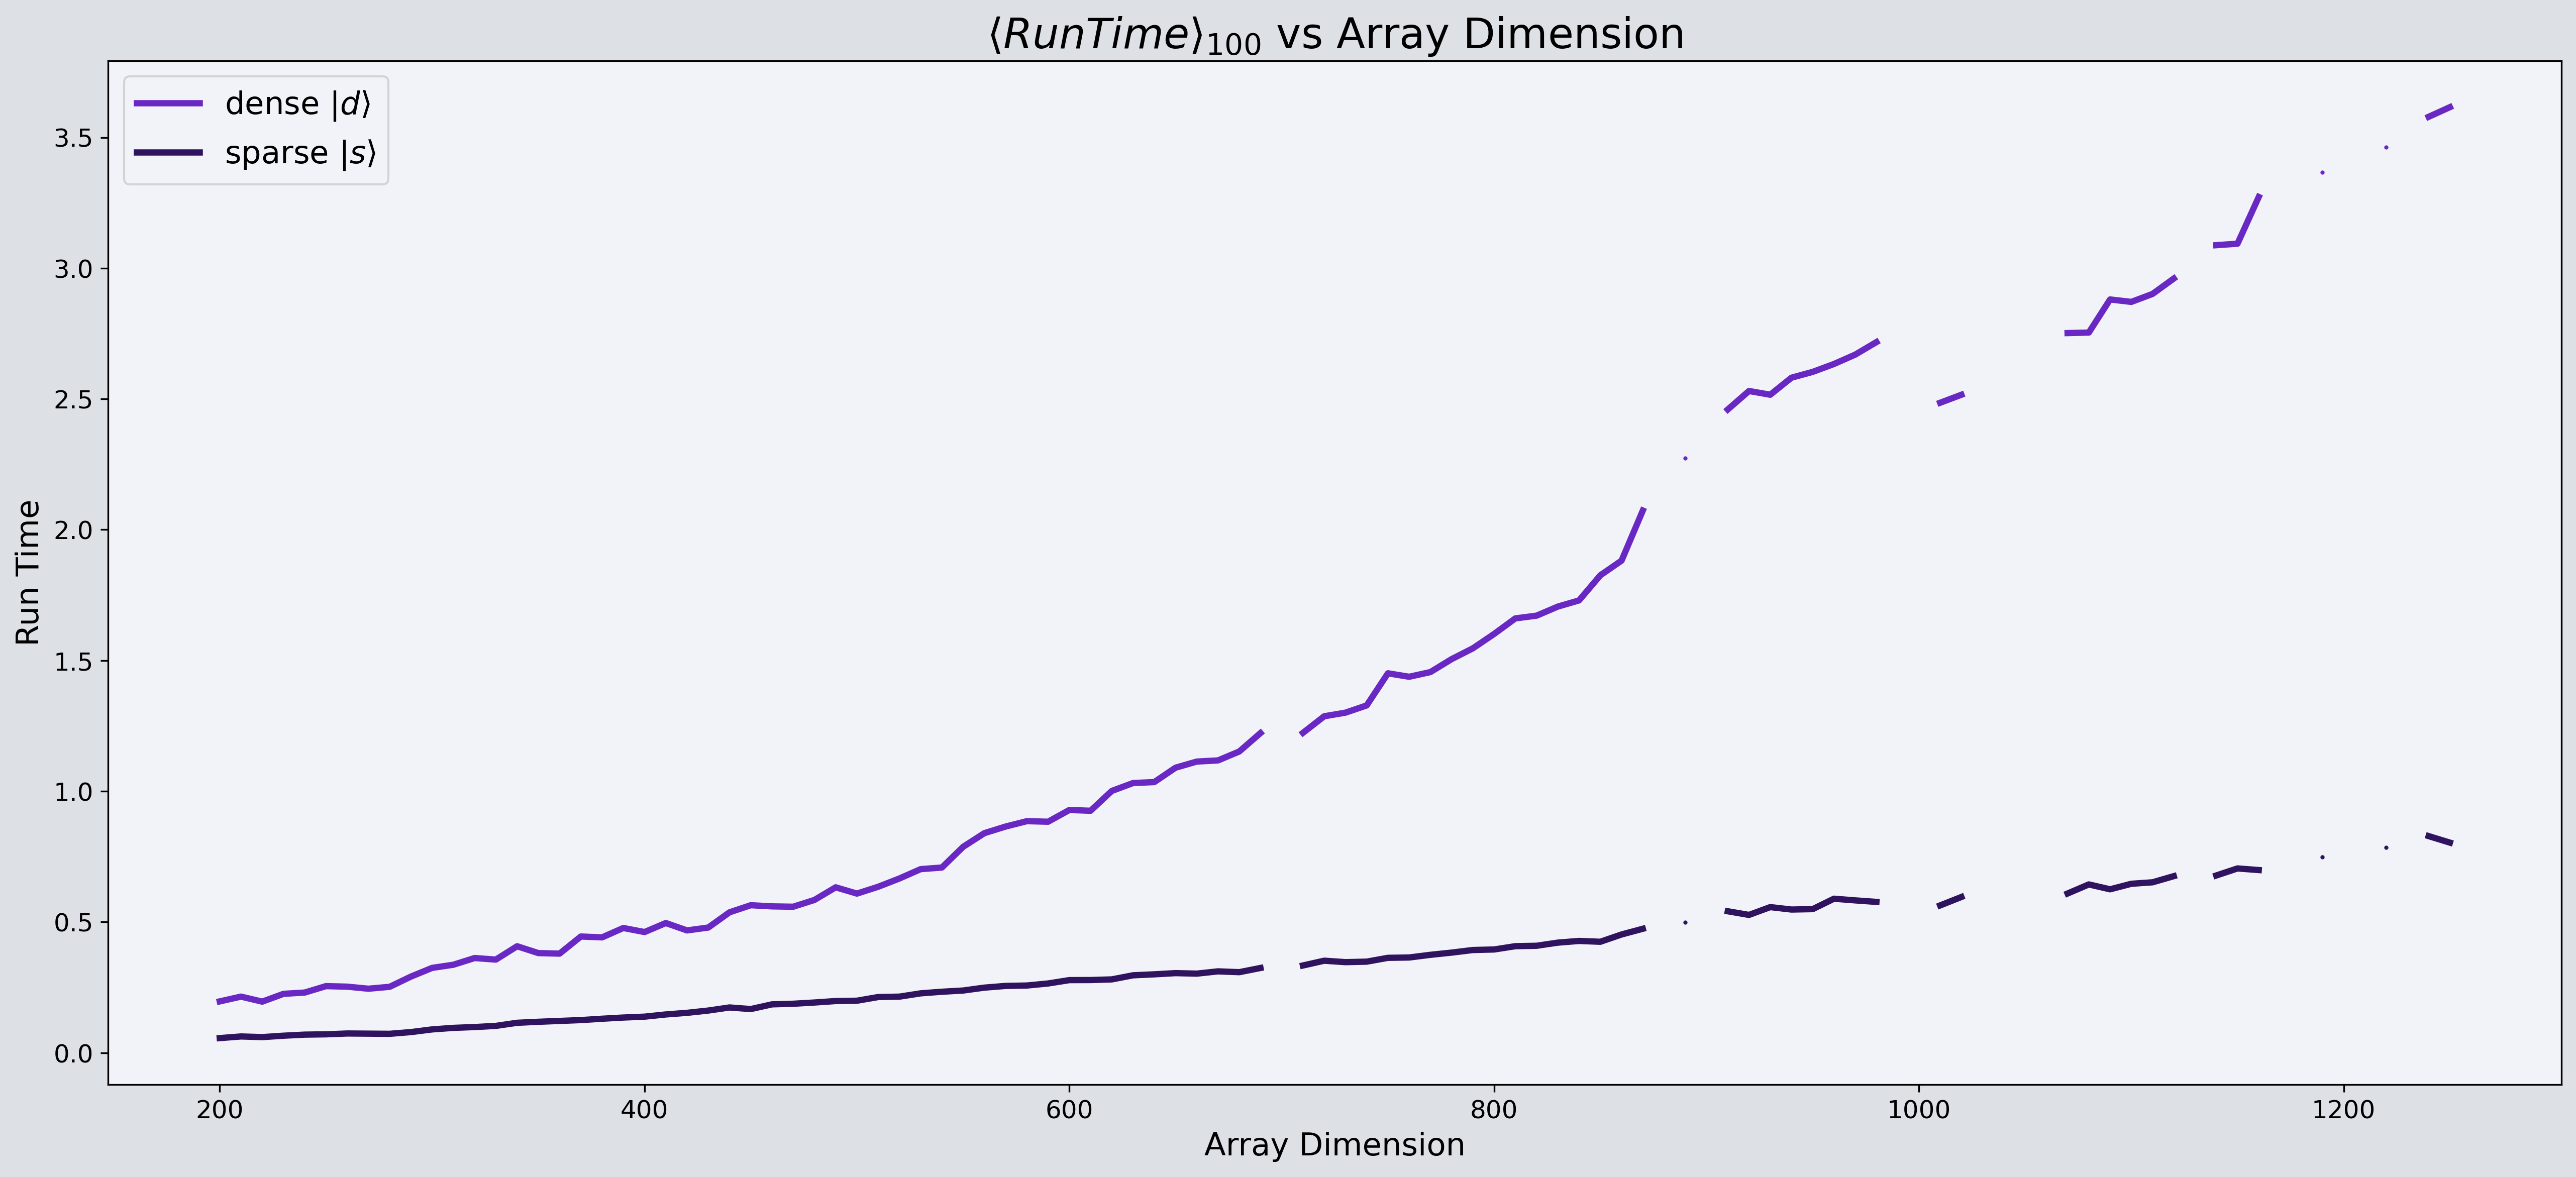

In [16]:
plt.rcParams['axes.facecolor']=background2

plt.figure(figsize=(21,9),dpi=300,facecolor=background1)
plt.plot(range(200,2015,10), np.array(runtime_vals)[:,0],'-o', markersize=1, linewidth=3,label='dense $|d \\rangle$',color=purple)
plt.plot(range(200,2015,10), np.array(runtime_vals)[:,1],'-o', markersize=1, linewidth=3,label='sparse $|s \\rangle$',color=darkpurple)
plt.xlabel('Array Dimension',fontsize=15)
plt.ylabel('Run Time',fontsize=15)
plt.title('$ \langle Run Time \\rangle_{100} $ vs Array Dimension',fontsize=20)
plt.legend(fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.savefig('dense-vs-sparse.png',bbox_inches='tight')